In [1]:
import os
from PIL import Image
import inferless
import torch
import cv2
from diffusers import ControlNetModel, AutoPipelineForImage2Image
from diffusers.utils import load_image
import numpy as np
import base64


from io import BytesIO

app = inferless.Cls(gpu="A10")

class InferlessPythonModel:
  

    @app.load
    def initialize(self):

        self.controlnet = ControlNetModel.from_pretrained(
            "diffusers/controlnet-depth-sdxl-1.0-small", # Smaller Depth ControlNet model
            torch_dtype=torch.float16,
            variant="fp16", 
            use_safetensors=True
        ).to("cuda")

        self.pipeline = AutoPipelineForImage2Image.from_pretrained(
            "stabilityai/sdxl-turbo", # Faster Turbo model
            controlnet=self.controlnet,
            torch_dtype = torch.float16,
            variant = "fp16",
            use_safetensors=True
        ).to("cuda")



    @app.infer
    def infer(self, inputs):

        
        # Load Image and turn it into PIL image
        img = inputs["image_bytes"]
        num_inference_steps = inputs['inference_steps']
        controlnet_conditioning_scale = inputs['controlet']
        guidance = inputs['guidance']
        prompt = inputs['prompt']


        img = load_image(img).resize((1024, 1024), Image.LANCZOS)
        control_image = self.preprocess_img(img)

        

        negative_prompt = "hair, deformed, fingers, sad, ugly, disgusting, uncanny, blurry, grainy, monochrome, duplicate, artifact, watermark, text"


        # Optional: set different generators for reproducibility
        seeds = [43, 44, 45]
        generators = [torch.manual_seed(seed) for seed in seeds]

        # Run batch if your pipeline supports it
        output_images = []

        

        with torch.inference_mode():
            tmp = self.pipeline(
                image=img,
                prompt= prompt,
                negative_prompt=negative_prompt,
                control_image=control_image,
                guidance_scale=guidance,
                controlnet_conditioning_scale=controlnet_conditioning_scale,
                num_inference_steps=num_inference_steps,
                height=1024,
                width=1024
            ).images
            output_images.append(tmp[0])
            del tmp
            torch.cuda.empty_cache()
            
                

        # Convert to base64
        output_images = [self.encode_base64(image) for image in output_images]
        return {"images": output_images}




    def finalize(self,args):
        self.pipeline = None
        self.controlnet = None



    def preprocess_img(self, img: Image, res: tuple[int, int] = (1024, 1024)):

        """Preprocesses the input image: Load, Grayscale, Resize, CLAHE, Denoise, Sharpen, Convert to RGB."""
        kernel = np.array([[0, -1, 0],
                    [-1, 5, -1],
                    [0, -1, 0]])


        img = img.convert("L")
        img_np = np.array(img)

        # Apply CLAHE for contrast enhancement
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        contrast_img = clahe.apply(img_np)

        # Denoise the image first
        denoised_img = cv2.fastNlMeansDenoising(contrast_img, h=7) # Denoising strength
        
        # Sharpen the denoised image
        sharpened_img = cv2.filter2D(denoised_img, -1, kernel) 

        final = Image.fromarray(sharpened_img)
        # Convert final grayscale image to RGB for the pipeline input
        return final.convert("RGB")

    def encode_base64(self, image: Image.Image, image_format: str = "PNG") -> str:
        """
        Encode a PIL image to a base64 string.

        Parameters:
            image (Image.Image): The PIL image to encode.
            image_format (str): Image format to use ("PNG", "JPEG", etc.)

        Returns:
            str: Base64-encoded image string.
        """
        buffered = BytesIO()
        image.save(buffered, format=image_format)

        img64 = base64.b64encode(buffered.getvalue()).decode("utf-8")
        if img64 is None:
            raise TypeError("Please check this goddam function")
        
        return img64 


In [2]:
modelo = InferlessPythonModel()
modelo.initialize()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [3]:

from IPython.display import display

def show_base64_image_notebook(base64_str: str):
    if ',' in base64_str:
        base64_str = base64_str.split(',')[1]
    
    image_data = base64.b64decode(base64_str)
    image = Image.open(BytesIO(image_data))
    display(image)

  0%|          | 0/2 [00:00<?, ?it/s]

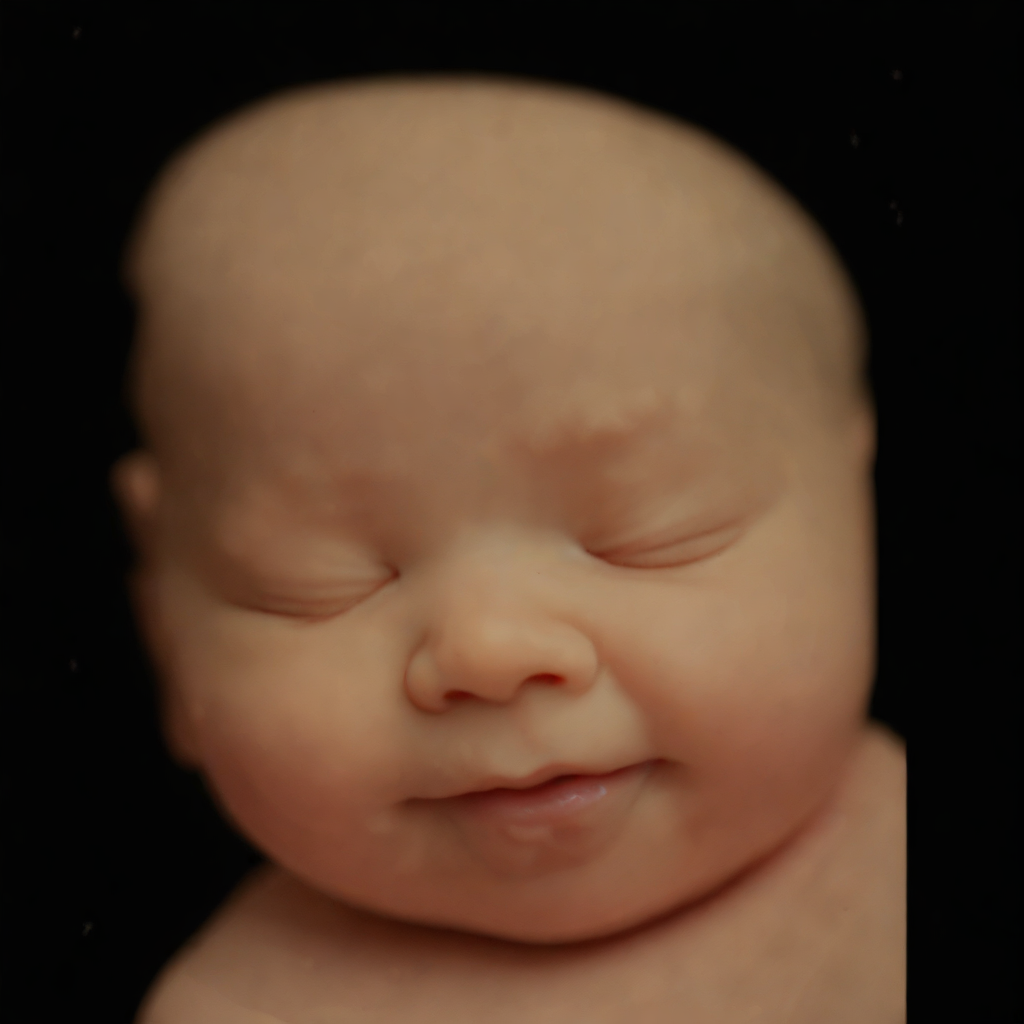

In [4]:
prompts = [
            "Photorealistic portrait of a cute asleep newborn baby, closed eyes, soft light, DSLR, 85mm lens",
            "Peaceful sleeping newborn baby, bald, close-up with detailed skin texture, photorealistic, pink skin, shallow depth of field",
            "Portrait of a sleeping newborn baby with closed eyes, resting peacefully in a soft womb-like environment, warm tones, detailed baby features"
        ]


out = modelo.infer({
    'image_bytes': "https://raw.githubusercontent.com/josho201/3dUltra/refs/heads/main/imgs/test%203.png",
    'prompt': prompts[0],
    'controlet': 0.8,
    'inference_steps': 3,
    'guidance': 1.25,

})

show_base64_image_notebook(out['images'][0])

In [6]:
out

{'images': ['iVBORw0KGgoAAAANSUhEUgAABAAAAAQACAIAAADwf7zUAAEAAElEQVR4nNz9zc4kS5IsiImoR10CMwTuJYnhYIhZEFwQXBB8/2ebSlflQkTULDLznDrdXdW8w+jqk/FFeLibqemP6I+p8X/6r/9Dz+edHrDf7ukegCBIQu9mpgoAMYA+JQhA7/yW/j//cd5jAAIzeguef5i7+ZZ+MyRnZp/QAxZnpupBnlcEBySLxGA0uOsuwBAcgtPQdzM8kxsOhvm8OOPxZMR5q/e+2rcG/ER9kUlhAI+c/v7MnphzIc8V/jivjBMZJ0Qplv4dzI4hUz4/9ZOWBhpbVuMsLIAZMkNhfje8x+IHACRFX3oducs23SAzBQJAT8+QmGlqmYo9JvXMgAQ5PVU1YgPddi4G0Qjz/loSP2bmm+y4eAxft8lPx9xx1oW+ZPmTJMQJXibq+qKoTo8jpK0sZ3GmzY1mq8kYON3g9Nso9uvB9kyR3VMXk4hCFylnRyz+mzP3ukly38Pj72bVDMih+T9ssXObwXAG4IwW7WF3s9DjKw+v+Q/fv7HUxIiVZ8T/xEqk5QTkzMwQxPTov9y1mBDU/MmszY5gvC51VmfXghcN9o8vGfYyhrv8QYuPgb61GUVd0ow3hwtWKa3eO+s1y6e41+X6g8tPRN30BIaY4exNpn0rjVh6q2eqOFOaZE+bH4iB5BKRotmR9CHELIOBdcjkkcALBLTvNYObzpoDfRd9/SW4uZXli/uDHdheETos4S1UPykoKYpd/WupbYzEOe+watBDsk3jMVtFvUt1SV5p7jqTC/vlK6vVKVKMKorYMOXpFwG5LDyrsfIOGHNd5bLLuN7EmYgCMd2tB81IwSIMsnS0Kh5N9suMWDTriNgcGo90jg1VLGdYV2SDde+E/yYrjvkWs/Ojlfk18md9RbCSHmOJvmVgcYvxcIgigOkOnwHTM5GT6XBpATNWVdbmuU0z+iCW/eLjigL

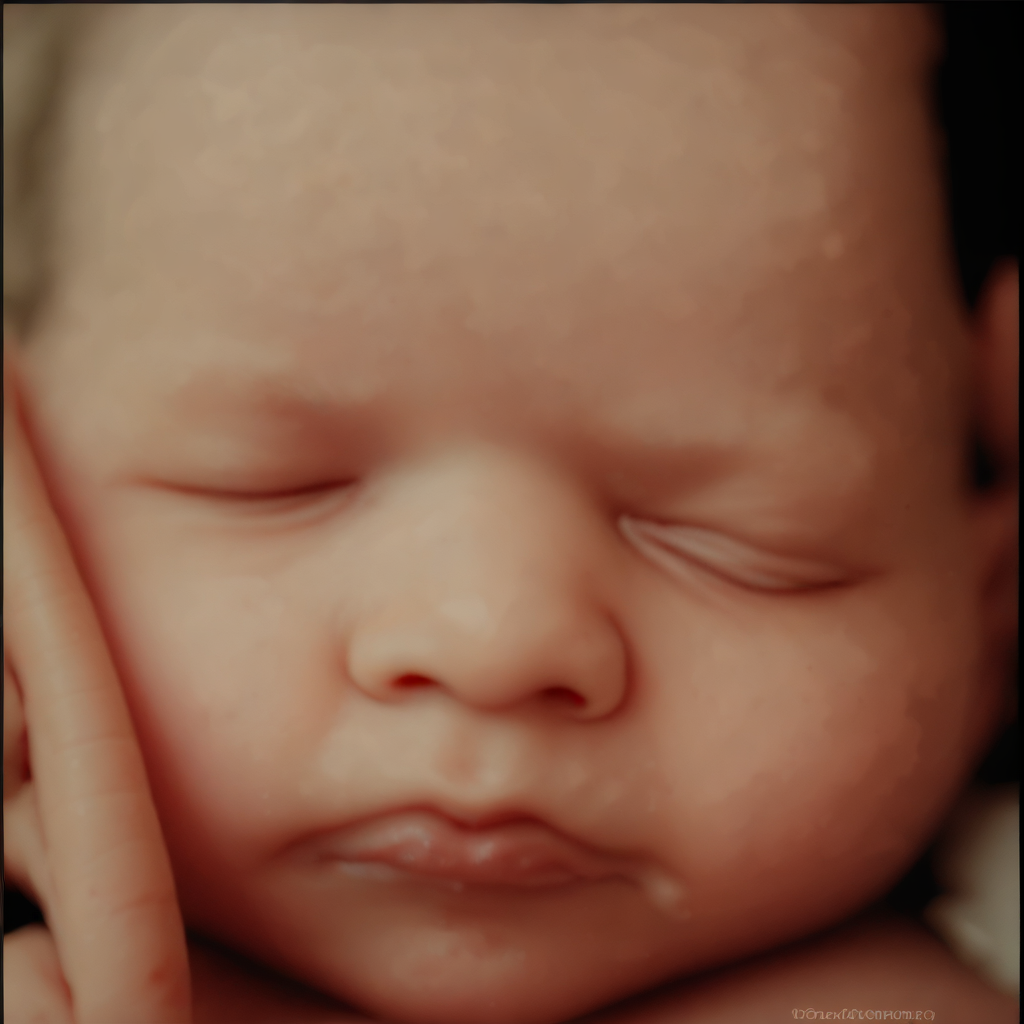